In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

import pandas as pd
import seaborn as sns

In [2]:
import datetime as dt
from dateutil.relativedelta import relativedelta 
from flask import Flask, jsonify, render_template
import os

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.inspection import inspect
from sqlalchemy import desc

In [4]:
# Create Engine for Hawaii Data 
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [9]:
# Start date and end date (range) for vacation is 7/4/2016 - 7/16/2016 Parse Dates
vacay_start_date_str = "2016-07-04"
vacay_end_date_str = "2016-07-16"
vacay_start_date = dt.datetime.strptime(vacay_start_date_str, '%Y-%m-%d')
vacay_end_date = dt.datetime.strptime(vacay_end_date_str, '%Y-%m-%d')
print(vacay_start_date, vacay_end_date)


2016-07-04 00:00:00 2016-07-16 00:00:00


In [10]:
# Parse dates
data_last_str = "2017-08-23"
data_last_date = dt.datetime.strptime(data_last_str, '%Y-%m-%d')
print(type(data_last_date), data_last_date)

<class 'datetime.datetime'> 2017-08-23 00:00:00


In [11]:
# Calculate the date 1 year ago from the last data point in the database
prev_year = data_last_date - relativedelta(years=1)
print(type(prev_year), prev_year)

<class 'datetime.datetime'> 2016-08-23 00:00:00


In [12]:
# Design a query to retrieve the last 12 months of precipitation data 
# Select only the `date` and `prcp` values
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= prev_year).all()
prcp_data[0:5]

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01)]

In [13]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
prcp_df = pd.DataFrame(prcp_data, columns= ['Date', 'Precipitation'])
prcp_df.set_index("Date",drop=True,inplace=True)
prcp_df.tail()

,Precipitation
Date,
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56
2017-08-22,0.50
2017-08-23,0.45


In [14]:
# Identify null values
nulls= prcp_df[prcp_df.isnull().any(axis=1)]
nulls.head()

,Precipitation
Date,
2016-09-05,NaN
2016-09-06,NaN
2016-08-31,NaN
2016-09-05,NaN
2016-09-12,NaN


In [15]:
# Drop null values found in the precipitation data
prcp_df =prcp_df.dropna(how="any")
prcp_df =prcp_df.sort_values("Date")
prcp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2015 entries, 2016-08-24 to 2017-08-23
Data columns (total 1 columns):
Precipitation    2015 non-null float64
dtypes: float64(1)
memory usage: 31.5+ KB


In [16]:
# Sort the DataFrame values by `date`
prcp_df = prcp_df.sort_values("Date")
prcp_df.tail()

,Precipitation
Date,
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.45


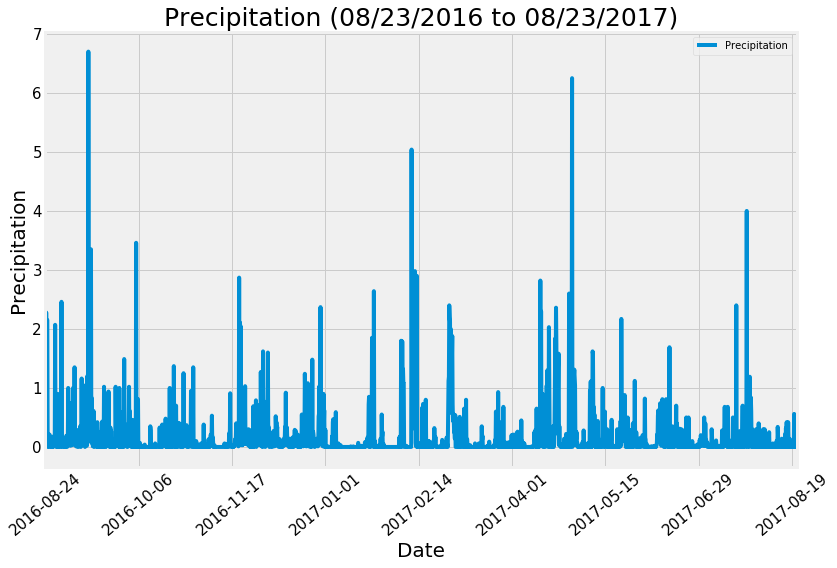

In [17]:
# Plot the results using the DataFrame `plot` method.
ax = prcp_df.plot(figsize=(12,8),fontsize = 15,rot= 40,x_compat=True)
ax.set_ylabel('Precipitation', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title("Precipitation (08/23/2016 to 08/23/2017)",fontsize=25)
plt.savefig('Images/preciptation.png', bbox_inches='tight')

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sum_stats_prcp = prcp_df.copy()
sum_stats_prcp.reset_index(inplace=True, drop=False)
sum_stats_prcp.head(1)
sum_stats_df = sum_stats_prcp[['Date', 'Precipitation']]
sum_stats_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to calculate the total number of stations.
stations= session.query(Station.station).distinct().all()
cnt=0
for row in stations:
    #print(row.station)
    cnt+=1
    if cnt > 10:
        break
station_cnt = session.query(Measurement.station).distinct().count()
station_cnt

9

In [20]:
# List the stations and the counts in descending order.
station_desc = session.query(Measurement.station,func.count(Measurement.station).label("s_count")).\
                    group_by(Measurement.station).\
                    order_by(desc("s_count")).\
                    all()
station_desc 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Which station has the highest number of observations?
high_sta = station_desc[0][0]
high_date = station_desc[0][1]
print(high_sta)
print(high_date)

USC00519281
2772


In [22]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Place into a DataFrame

tobs_data = engine.execute('SELECT date, tobs FROM Measurement WHERE station ="USC00519281" AND date > "2016-08-23"').fetchall()
tobs_data_df = pd.DataFrame(tobs_data, columns= ['Date', 'Tobs'])
tobs_data_df.head()

,Date,Tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


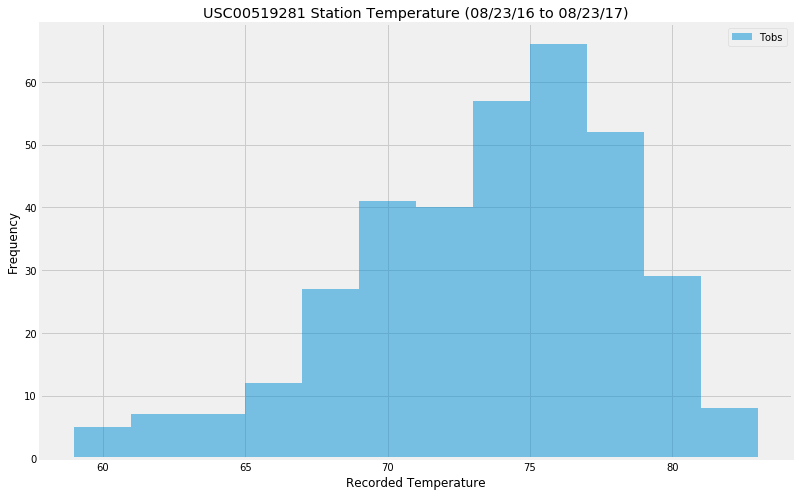

In [23]:
# Plot the results as a histogram with bins=12.
tobs_data_df.plot.hist(bins =12, alpha =.5, figsize =(12,8)) 
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title(high_sta + " Station Temperature (08/23/16 to 08/23/17)" )
plt.savefig('Images/tobs.png', bbox_inches='tight')

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps(vacay_start_date_str, vacay_end_date_str))
bar_values = calc_temps(vacay_start_date_str, vacay_end_date_str)
print(bar_values[0][0])

[(71.0, 76.97674418604652, 82.0)]
71.0


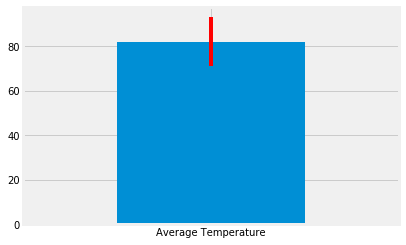

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(0,bar_values[0][2], width=1, tick_label=["Average Temperature"])
plt.xlim(-1,1) 
plt.errorbar(0, bar_values[0][2], yerr= (bar_values[0][2]-bar_values[0][0]), color ="red")
plt.savefig('Images/tobs-bar.png', bbox_inches='tight')
